# 라이브러리 가져오기
인공 신경망 구축을 위한 텐서플로우, csv 파일 핸들링을 위한 판다스, 행렬 조작을 위한 넘파이를 가져온다

In [1]:
import os
import ray
import random
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from keras_radam.training import RAdamOptimizer


# 분산처리 라이브러리 ray 초기화하기

In [2]:
ray.init()

2020-10-25 03:36:33,094	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.108',
 'raylet_ip_address': '192.168.68.108',
 'redis_address': '192.168.68.108:6379',
 'object_store_address': '/tmp/ray/session_2020-10-25_03-36-32_641639_273069/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-25_03-36-32_641639_273069/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-10-25_03-36-32_641639_273069',
 'metrics_export_port': 62534}

# GPU 사용 관련 설정

In [3]:
import tensorflow as tf
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# 이미지 사이즈 설정하기
이미지를 가져온 다음, 신경망에 쉽게 적용하기 위해 리사이징이 필요하다. 리사이징을 어느 정도로 할지 정하는 파라미터이다

In [4]:
IMAGE_SIZE=[256, 256] 

# 시각화 스타일 설정하기

In [5]:
plt.style.use("seaborn")

# 데이터 로딩하기

## 경로 설정

In [6]:
base_dir = "/home/bellmanlabs/HDD1/kaggle/plant-pathology-2020-fgvc7"
image_dir = os.path.join(base_dir, "images")
train_csv_path = os.path.join(base_dir, "train.csv")
test_csv_path = os.path.join(base_dir, "test.csv")

## 정답 레이블이 담긴 데이터프레임 가져오기

In [7]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

## 데이터프레임 확인하기
image_id: 각 이미지의 고유 id. 레이블과 이미지를 매칭하는 데 쓴다  
healthy: 식물이 건강한 경우.  
multiple_diseases: 식물이 복합적인 병을 가진 경우.  
rust: 식물이 녹병균에 걸린 경우.  
scab: 식물 잎에 딱지가 많이 앉은 경우

In [8]:
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

## 데이터셋 분포 확인하기
다른 레이블에 비해 multiple_diseases(복합적인 병에 걸린 경우) 가 적은 것을 볼 수 있다.

<BarContainer object of 4 artists>

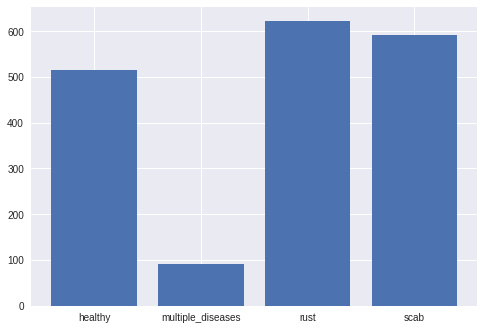

In [9]:
plt.bar(train_df.columns[1:], [train_df[x].sum() for x in train_df.columns[1:]])

## 데이터 imbalance 수정하기
데이터의 한 레이블이 과도하게 작으면 학습이 안정적으로 되지 않을 수 있다.  
따라서 imbalance한 데이터를 다루기 위한 방법 중 가장 간단한 방법을 적용한다.  
바로 부족한 레이블의 갯수를 다른 레이블과 비슷한 수준으로 맞춰주는 것이다.

In [10]:
n = np.mean([[len(list(train_df[train_df[x] == 1].index)) for x in ["healthy", "rust", "scab"]]]) // len(list(train_df[train_df["multiple_diseases"] == 1].index))
appender = pd.DataFrame(train_df[train_df["multiple_diseases"] == 1])
for _ in range(int(n)):
    train_df = train_df.append(appender)

In [11]:
train_ids = train_df["image_id"].to_list()

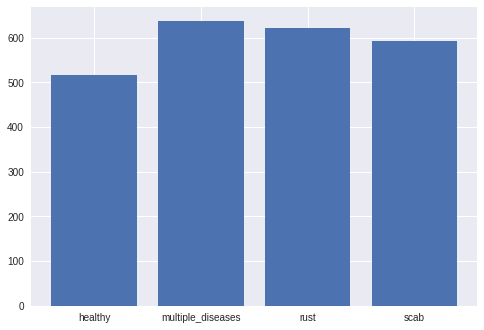

In [12]:
plt.bar(train_df.columns[1:], [train_df[x].sum() for x in train_df.columns[1:]])
train_df = train_df.drop_duplicates()

# 이미지 시각화하기

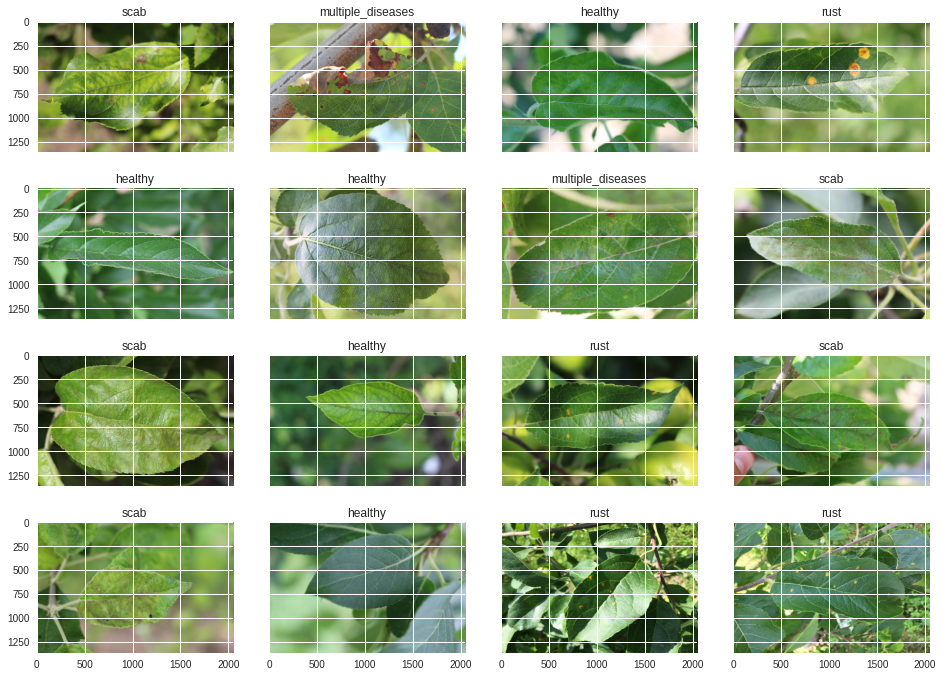

In [13]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, image_id in zip(grid, [x for x in train_df["image_id"][:4*4]]):
    # Iterating over the grid returns the Axes.
    im = Image.open(os.path.join(image_dir, image_id + ".jpg"))
    title = train_df.columns[1:][train_df.loc[train_df["image_id"] == image_id][train_df.columns[1:]].values.argmax()]
    ax.set_title(title)
    ax.imshow(im)

plt.show()

# 이미지 전처리하기
이미지를 로딩하고 사이즈를 바꾼 다음 이미지 행렬을 0~1사이의 값으로 바꿔준다

In [14]:
@ray.remote
def load_preprocess_image(image_id, resize_to=IMAGE_SIZE):
    path = os.path.join(image_dir, image_id + ".jpg")
    image_arr = np.array(Image.open(path).resize(resize_to)) / 255
    return image_arr

def load_label(image_id):
    return train_df.loc[train_df["image_id"] == image_id][train_df.columns[1:]].values.squeeze()

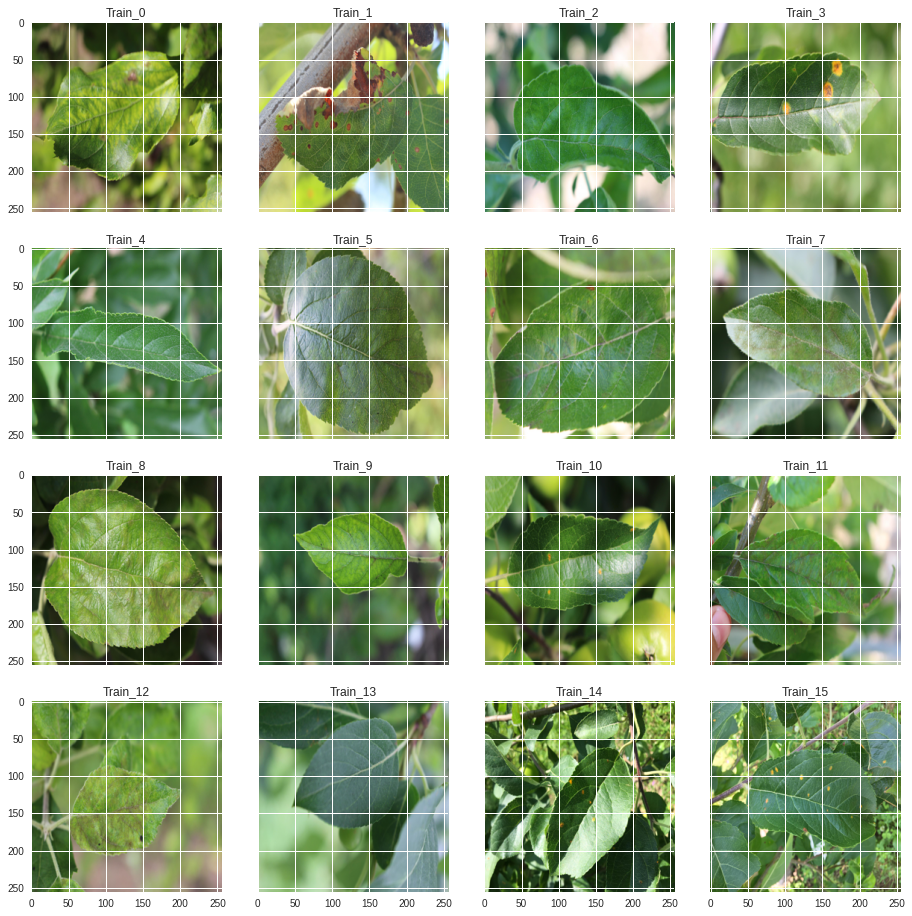

In [15]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, image_id in zip(grid, [x for x in train_df["image_id"][:4*4]]):
    # Iterating over the grid returns the Axes.
    im = ray.get(load_preprocess_image.remote(image_id))
    ax.set_title(image_id)
    ax.imshow(im)

plt.show()

# 데이터 로딩하기

In [16]:
image_ids = np.array(train_ids)
np.random.shuffle(image_ids)

train_image_ids = image_ids[:int(len(image_ids)*0.8)]
validation_image_ids = image_ids[int(len(image_ids)*0.8):]

In [17]:
train_x = [load_preprocess_image.remote(image_id) for image_id in train_image_ids]
train_x = np.array([ray.get(x) for x in train_x])
train_y = np.array([load_label(image_id) for image_id in train_image_ids])

val_x = [load_preprocess_image.remote(image_id) for image_id in validation_image_ids]
val_x = np.array([ray.get(x) for x in val_x])
val_y = np.array([load_label(image_id) for image_id in validation_image_ids])

# 모델 만들기
합성곱 신경망(Convolutional Neural Networks)를 기반으로 한 DenseNet모델을 사용한다.  
<a href="https://arxiv.org/abs/1608.06993">Densely Connected Convolutional Networks(Heung et al, 2016)
<img src="https://miro.medium.com/max/2436/1*vIZhPImFr9Gjpx6ZB7IOJg.png">

In [18]:
# load pre-trained DenseNet
base_model = applications.DenseNet121(include_top=False, input_shape=IMAGE_SIZE + [3]) 

# add fully-connected layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(4, activation="softmax")(x)

# package model
model = models.Model(inputs=base_model.input, outputs=x)

# complie model
model.compile(loss="categorical_crossentropy", optimizer=RAdamOptimizer(min_lr=1e-7), metrics=["accuracy"])

# 모델 구조

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# 훈련하고 훈련 상황 그래프 시각화하기
훈련 데이터셋에서 98% 정확도, 밸리데이션(훈련 검증) 데이터에서 96% 정확도로 마감하였다. 학습이 어느정도 잘 되었다고 볼 수 있다

In [20]:
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, batch_size=12)

Epoch 1/20
158/158 [==============================] - 30s 189ms/step - loss: 0.5853 - accuracy: 0.7591 - val_loss: 0.4050 - val_accuracy: 0.8734
Epoch 2/20
158/158 [==============================] - 25s 159ms/step - loss: 0.3020 - accuracy: 0.8996 - val_loss: 0.2261 - val_accuracy: 0.9262
Epoch 3/20
158/158 [==============================] - 25s 159ms/step - loss: 0.3004 - accuracy: 0.8885 - val_loss: 0.5342 - val_accuracy: 0.8186
Epoch 4/20
158/158 [==============================] - 25s 159ms/step - loss: 0.2010 - accuracy: 0.9308 - val_loss: 0.7026 - val_accuracy: 0.7342
Epoch 5/20
158/158 [==============================] - 25s 159ms/step - loss: 0.2253 - accuracy: 0.9186 - val_loss: 2.5921 - val_accuracy: 0.6203
Epoch 6/20
158/158 [==============================] - 25s 159ms/step - loss: 0.1880 - accuracy: 0.9414 - val_loss: 0.1562 - val_accuracy: 0.9451
Epoch 7/20
158/158 [==============================] - 25s 159ms/step - loss: 0.1567 - accuracy: 0.9530 - val_loss: 0.9573 - val_ac

In [21]:
model.save("./model_plant.h5") # 모델 저장하기

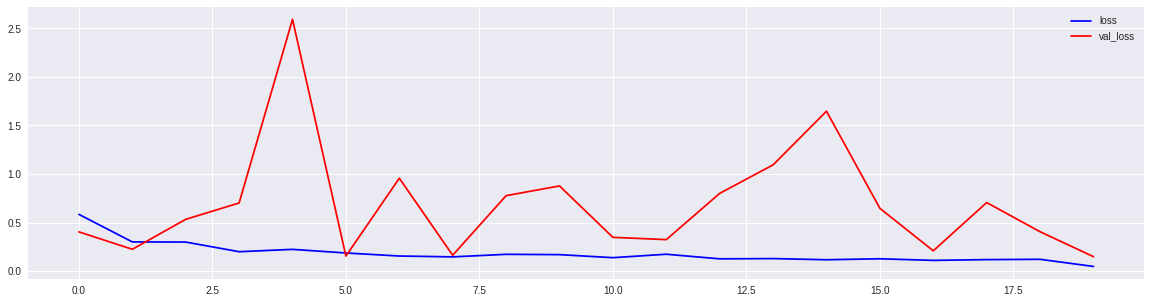

In [22]:
plt.figure(figsize=(20,5 ))
plt.plot(hist.history["loss"], color="b", label="loss")
plt.plot(hist.history["val_loss"], color="r", label="val_loss")
plt.legend()

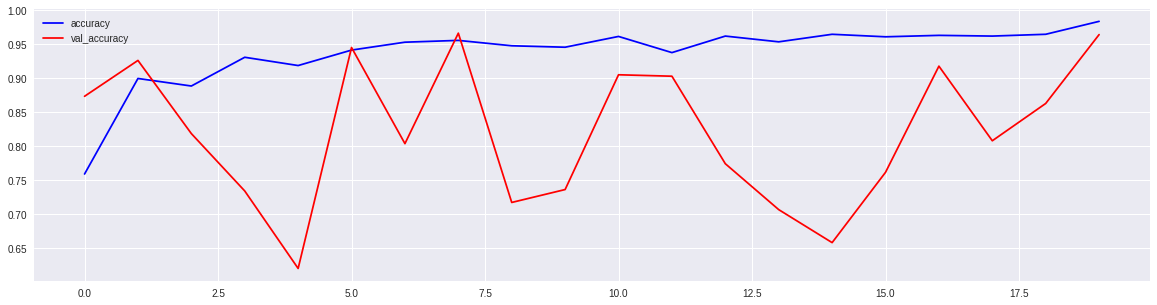

In [23]:
plt.figure(figsize=(20,5 ))
plt.plot(hist.history["accuracy"], color="b", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="r", label="val_accuracy")
plt.legend()

# 정답이 없는 데이터에 대해 추론하기
육안으로 보았을 때 분류를 꽤 잘 하는 것을 볼 수 있다.

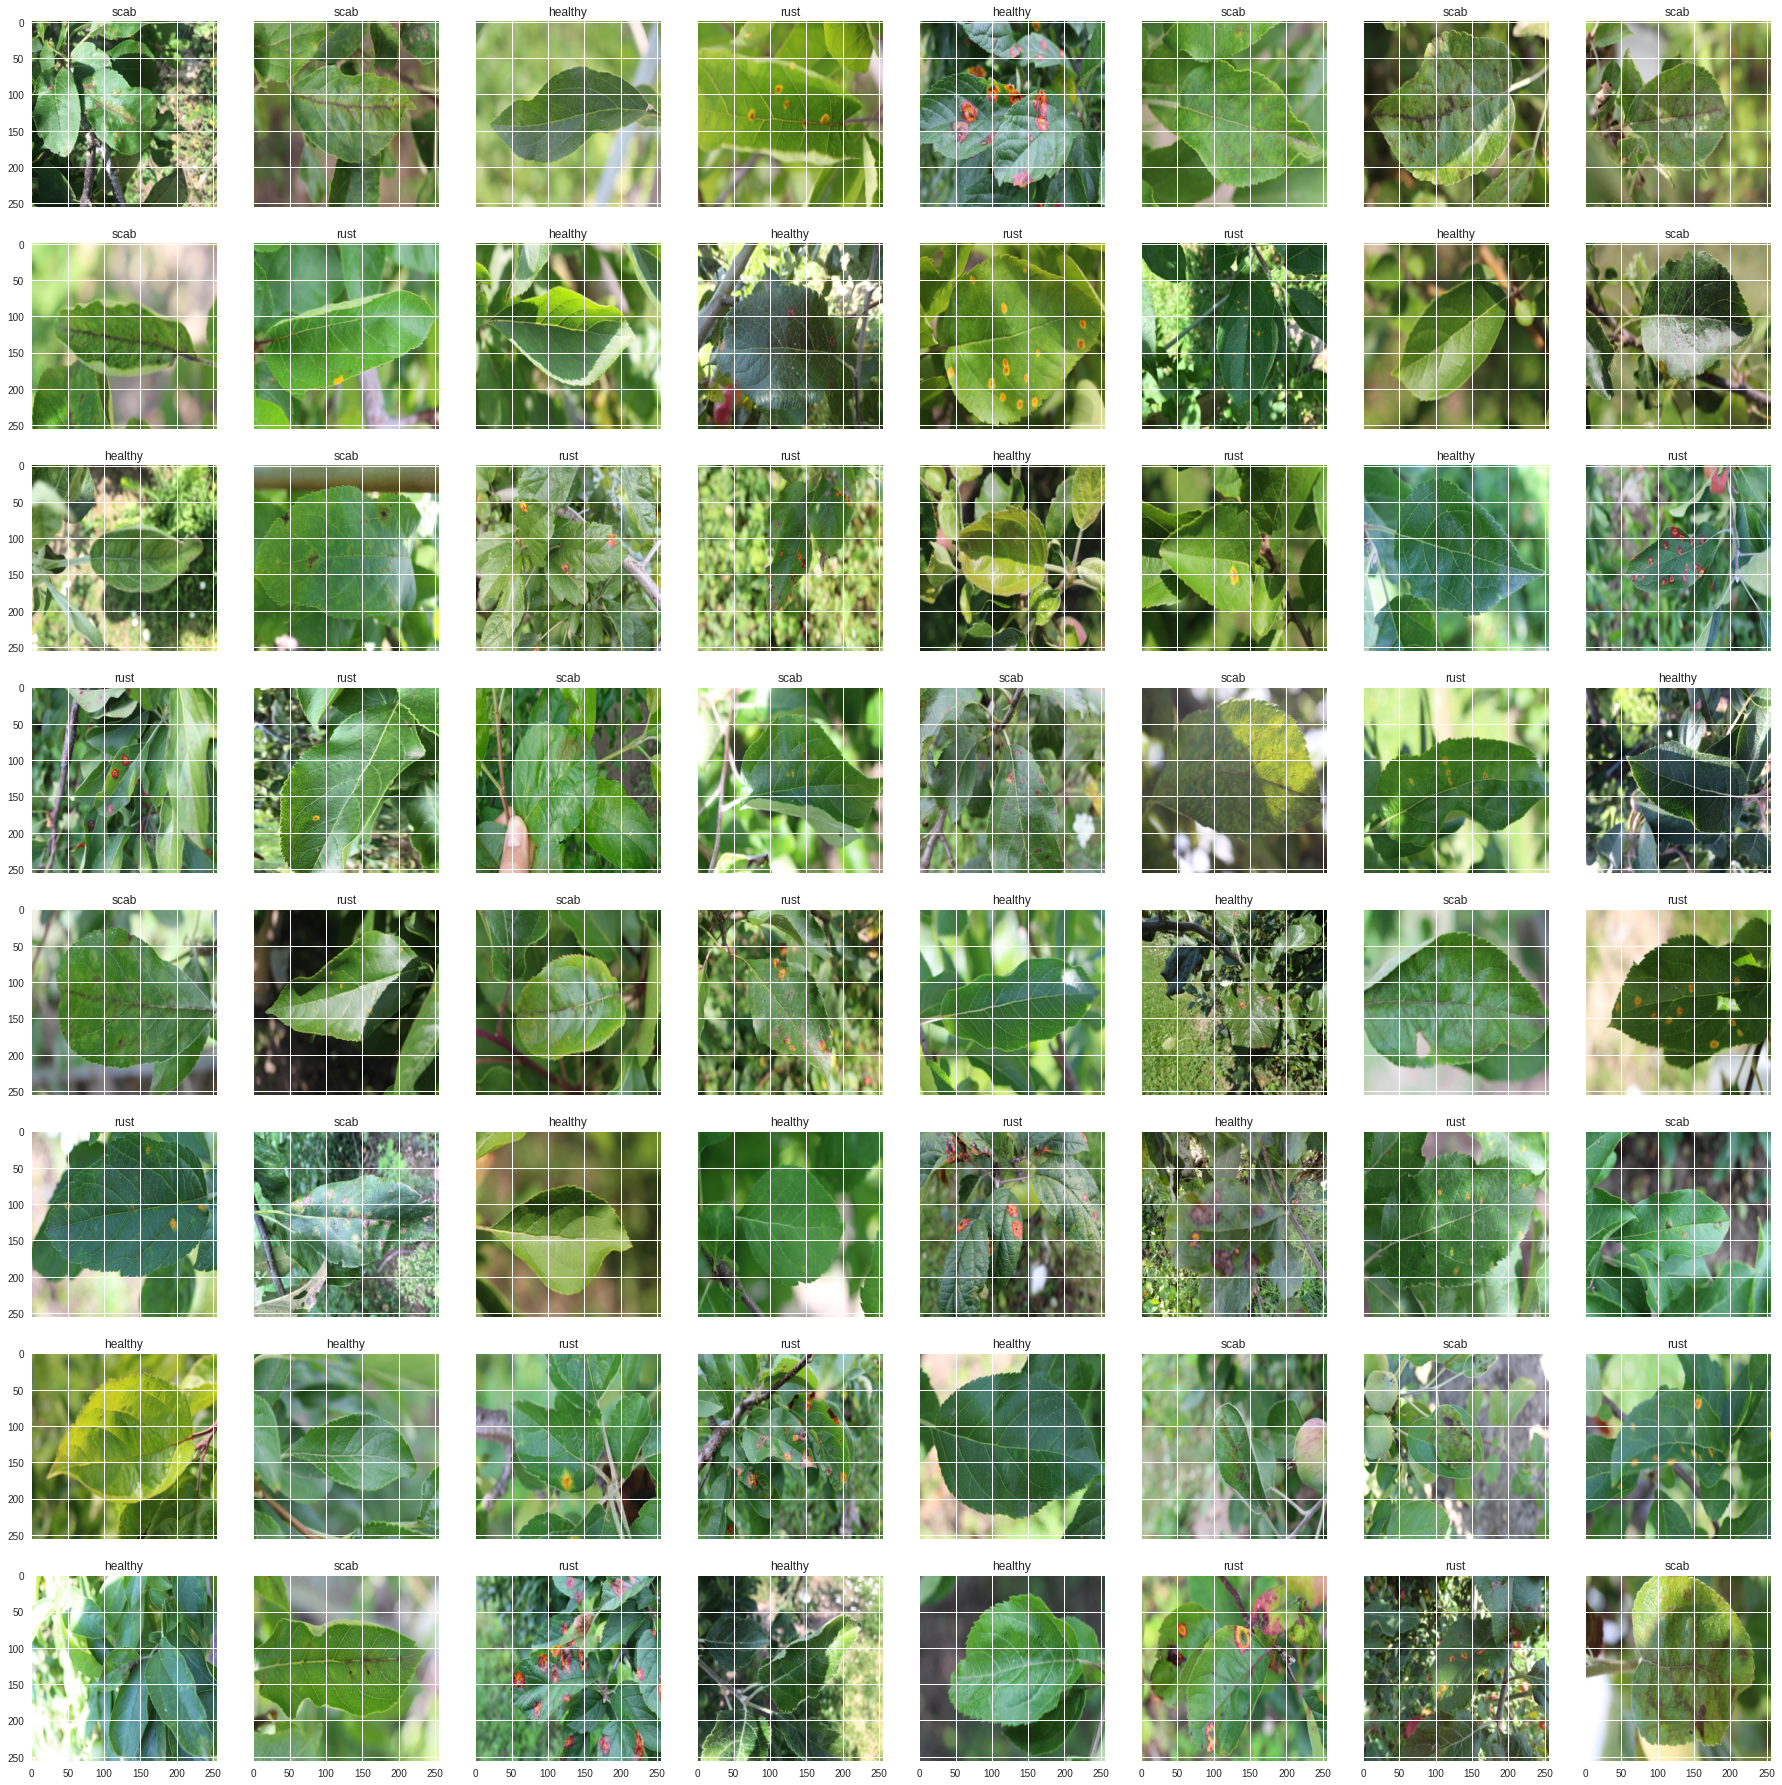

In [24]:
labels = list(train_df.columns[1:])
number_label_dict = {labels.index(x):x for x in labels}

fig = plt.figure(figsize=(32., 32.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, image_id in zip(grid, random.sample(test_df["image_id"].to_list(), 64)):
    # Iterating over the grid returns the Axes.
    im = ray.get(load_preprocess_image.remote(image_id))
    ax.set_title(number_label_dict[model.predict(np.array([im])).argmax(1).item()])
    ax.imshow(im)

plt.show()

# 정답이 없는 데이터에 대한 추론 결과 저장

In [25]:
submission_df = pd.read_csv(os.path.join(base_dir, "sample_submission.csv"))

test_x = [load_preprocess_image.remote(image_id) for image_id in submission_df["image_id"].values]
test_x = np.array([ray.get(x) for x in test_x])

predictions = model.predict(test_x)

submission_df[submission_df.columns[1:]] = predictions


In [26]:
submission_df.to_csv(os.path.join(base_dir, "sample_submission.csv"), index=False)